# Data Mining Project
## Konstantinos Georgiou
Dataset: [COVID-19 World Vaccination Progress](https://www.kaggle.com/gpreda/covid-world-vaccination-progress)

## Information About The Dataset

This dataset contains information about the vaccinations happening in each country daily. The data are being collected almost daily from this website using this code. As of writing this (2/27), the dataset has 4,380 rows with vaccination data for 112 unique countries and is in the CSV format.

It has 15 columns in total, including among others the country name, the daily vaccination, the vaccinated people per million that date, and the source of each record.

- Country- this is the country for which the vaccination information is provided;
- Country ISO Code - ISO code for the country;
- Date - date for the data entry; for some of the dates we have only the daily vaccinations, for others, only the (cumulative) total;
- Total number of vaccinations - this is the absolute number of total immunizations in the country;
- Total number of people vaccinated - a person, depending on the immunization scheme, will receive one or more (typically 2) vaccines; at a certain moment, the number of vaccination might be larger than the number of people;
- Total number of people fully vaccinated - this is the number of people that received the entire set of immunization according to the immunization scheme (typically 2); at a certain moment in time, there might be a certain number of people that received one vaccine and another number (smaller) of people that received all vaccines in the scheme;
- Daily vaccinations (raw) - for a certain data entry, the number of vaccination for that date/country;
- Daily vaccinations - for a certain data entry, the number of vaccination for that date/country;
- Total vaccinations per hundred - ratio (in percent) between vaccination number and total population up to the date in the country;
- Total number of people vaccinated per hundred - ratio (in percent) between population immunized and total population up to the date in the country;
- Total number of people fully vaccinated per hundred - ratio (in percent) between population fully immunized and total population up to the date in the country;
- Number of vaccinations per day - number of daily vaccination for that day and country;
- Daily vaccinations per million - ratio (in ppm) between vaccination number and total population for the current date in the country;
- Vaccines used in the country - total number of vaccines used in the country (up to date);
- Source name - source of the information (national authority, international organization, local organization etc.);
- Source website - website of the source of information;


## Questions To Be Answered

- Can you identify countries that faced bottlenecks on their daily vaccination rates?
- Can you cluster together countries that faced similar bottlenecks? In what sense are they related?
- Can you enrich the data with more info (country location, GDP, etc) to achieve better results on the previous question?
- Can you track down the bottlenecks and find patterns in how they propagate from day to day from one cluster to another?
- Can you predict future bottlenecks on some clusters based on these patterns?

## Some details
- To setup this project on any machine, just run `make install`. More details in the [Readme](README.md).
- To download the latest version of the dataset (new rows are added every day), run `make download_dataset`
- The dataset is in the <a>datasets/covid-world-vaccinations-progress</a> directory
- In the [data mining directory](data_mining) are located three custom packages:
    - Configuration: for handling the yml configuration
    - ColorizedLogger: For formatted logging that saves output in log files
    - timeit: ContextManager&Decorator for timing functions and code blocks
- The project was compiled using my Template **Cookiecutter** project: <a>https://github.com/drkostas/starter</a>

## Code

### Load Libraries and configuration
Configuration path: `confs/covid.yml`

In [1]:
from data_mining import timeit, ColorizedLogger, Configuration
import data_mining.project_utils.nulls_fixer as nullib
text_color = 'lightgrey'
# text_color = 'black'

In [66]:
from importlib import reload as reload_lib
import numpy as np
import pandas as pd
import missingno as msno
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 
pd.set_option('display.max_rows', 500)

In [3]:
# Load the configuration
conf_obj = Configuration(config_src='confs/covid.yml')
covid_conf = conf_obj.get_config('covid-progress')[0]
data_path = covid_conf['properties']['data_path']
data_extra_path = covid_conf['properties']['data_extra_path']
log_path = covid_conf['properties']['log_path']

2021-04-20 14:02:48 Config       INFO     Configuration file loaded successfully from path: /home/drkostas/GDrive/Projects/UTK/COSC526-Project/confs/covid.yml
2021-04-20 14:02:48 Config       INFO     Configuration Tag: project


### Setup logging, Load the Dataset

In [4]:
# Setup the Logger
logger = ColorizedLogger(logger_name='JupyterMain', color='yellow')
ColorizedLogger.setup_logger(log_path=log_path, debug=False)

2021-04-20 14:02:48 FancyLogger  INFO     Logger is set. Log file path: /home/drkostas/GDrive/Projects/UTK/COSC526-Project/logs/covid_progress.log


In [5]:
# Load the dataset
if covid_conf['type'] == 'csv':
    covid_orig_df = pd.read_csv(data_path)
    logger.info("Dataset loaded.")
else:
    logger.error('Data type not supported!')


2021-04-20 14:02:48 JupyterMain  INFO     Dataset loaded.


### Explore the dataset

In [6]:
# Print Columns info
logger.info(f"Dataframe shape: {covid_orig_df.shape}")
covid_orig_df.info()

2021-04-20 14:02:48 JupyterMain  INFO     Dataframe shape: (9576, 15)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9576 entries, 0 to 9575
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              9576 non-null   object 
 1   iso_code                             9576 non-null   object 
 2   date                                 9576 non-null   object 
 3   total_vaccinations                   5772 non-null   float64
 4   people_vaccinated                    5167 non-null   float64
 5   people_fully_vaccinated              3608 non-null   float64
 6   daily_vaccinations_raw               4816 non-null   float64
 7   daily_vaccinations                   9393 non-null   float64
 8   total_vaccinations_per_hundred       5772 non-null   float64
 9   people_vaccinated_per_hundred        5167 non-null   float64
 10  people_fully_vaccinated_per_hundred  3608 non-null   float64
 11  daily_vaccinations_per_million

In [7]:
# Transform Date to a datetime column
covid_orig_df['date'] = pd.to_datetime(covid_orig_df.date)

In [8]:
# Print the statistics of the Dataset
covid_orig_df.describe()

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
count,5.772000e+03,5.167000e+03,3.608000e+03,4.816000e+03,9.393000e+03,5772.000000,5167.000000,3608.000000,9393.000000
mean,3.223423e+06,2.406510e+06,1.076638e+06,1.115403e+05,6.705204e+04,11.486305,8.540521,4.171486,2835.473651
std,1.198154e+07,8.122148e+06,4.359236e+06,4.026947e+05,2.645468e+05,19.689933,13.053528,8.765672,4994.852975
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,4.589425e+04,4.177000e+04,1.999125e+04,2.972250e+03,9.730000e+02,0.870000,0.860000,0.440000,361.000000
50%,3.091255e+05,2.723230e+05,1.251490e+05,1.453950e+04,5.979000e+03,4.350000,3.520000,1.595000,1398.000000
75%,1.522704e+06,1.157205e+06,5.511082e+05,6.057000e+04,2.824500e+04,13.192500,9.950000,3.910000,3474.000000
max,1.616884e+08,1.042135e+08,5.985815e+07,7.185000e+06,5.190143e+06,180.780000,95.850000,84.930000,118759.000000


In [9]:
# Print the first two rows
covid_orig_df.head(n=2).transpose()

,0,1
country,Afghanistan,Afghanistan
iso_code,AFG,AFG
date,2021-02-22 00:00:00,2021-02-23 00:00:00
total_vaccinations,0.0,NaN
people_vaccinated,0.0,NaN
people_fully_vaccinated,NaN,NaN
daily_vaccinations_raw,NaN,NaN
daily_vaccinations,NaN,1367.0
total_vaccinations_per_hundred,0.0,NaN
people_vaccinated_per_hundred,0.0,NaN


2021-04-20 14:02:48 JupyterMain  INFO     Country ISO Value Counts:
OWID_WLS    111
OWID_ENG    111
OWID_NIR    111
CAN         111
OWID_SCT    111
GBR         111
RUS         110
CHN         109
ISR         106
USA         105
QAT         103
BHR         102
CHL         101
MEX         101
Name: iso_code, dtype: int64

2021-04-20 14:02:48 JupyterMain  INFO     Types of Vaccines Value Counts:
Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                         2255
Pfizer/BioNTech                                                      1435
Oxford/AstraZeneca                                                   1331
Oxford/AstraZeneca, Pfizer/BioNTech                                  1154
Pfizer/BioNTech, Sinovac                                              426
Sputnik V                                                             388
Moderna, Pfizer/BioNTech                                              370
Oxford/AstraZeneca, Sinovac                                           268
Sinopharm/Be

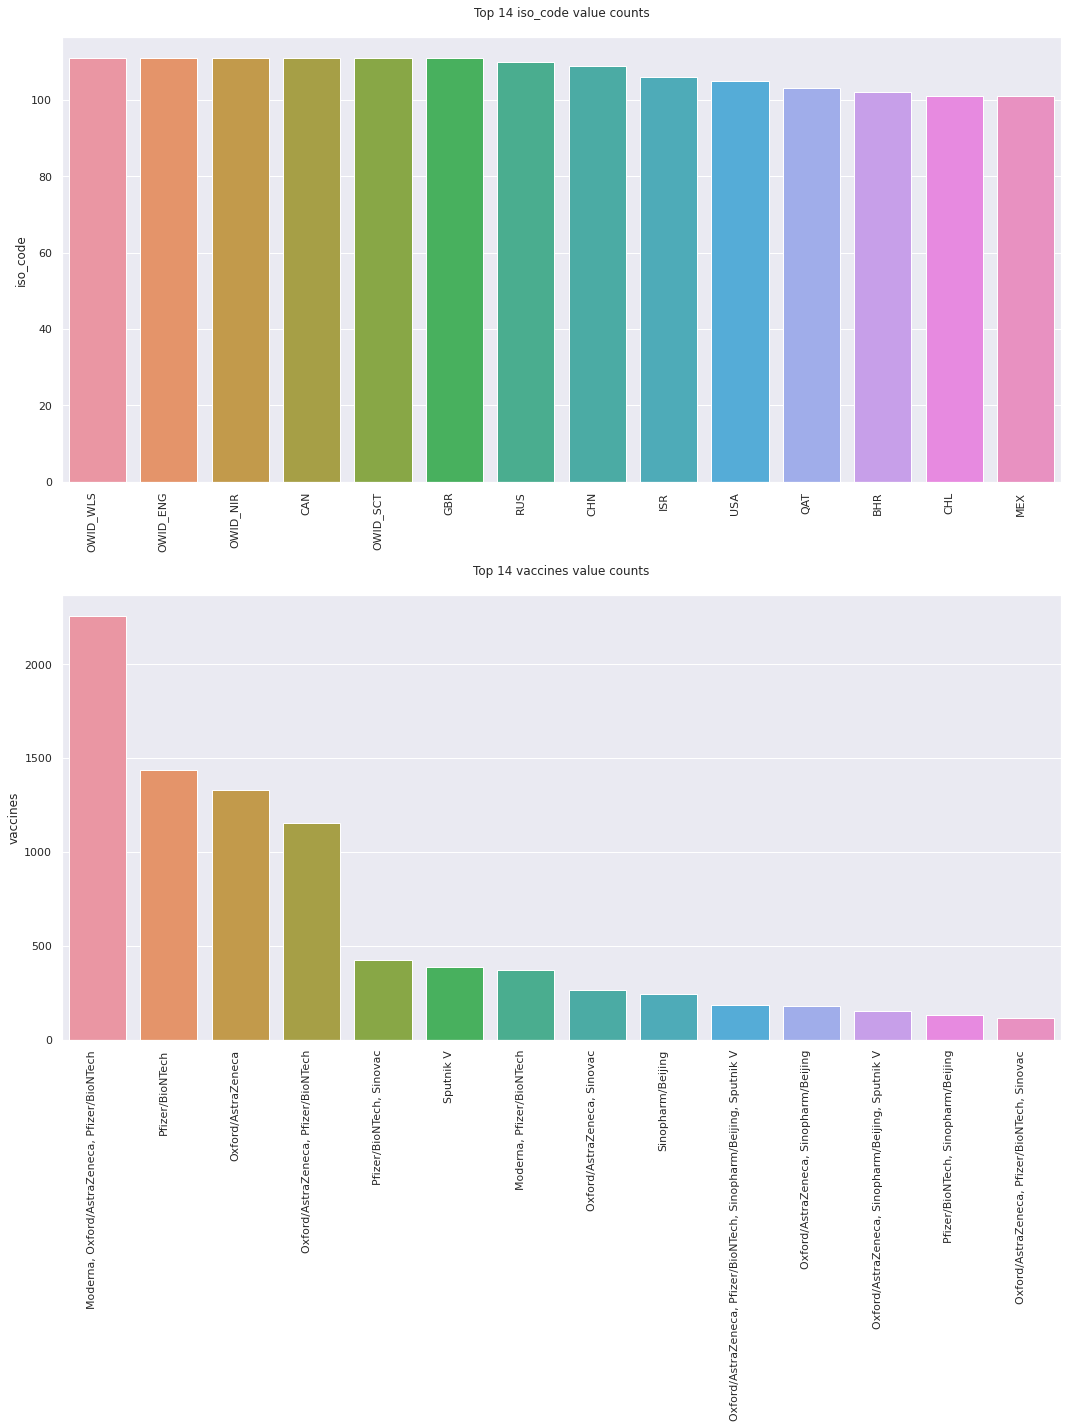

In [10]:
# Print top 10 Value counts for two important categorical columns
def viz_iso_and_vaccine_val_counts(covid_orig_df, top=10):
    val_cnts = {}
    val_cnts['iso_code'] = covid_orig_df['iso_code'].value_counts().nlargest(top)
    val_cnts['vaccines'] = covid_orig_df['vaccines'].value_counts().nlargest(top)
    logger.info(f"Country ISO Value Counts:\n{val_cnts['iso_code']}\n")
    logger.info(f"Types of Vaccines Value Counts:\n{val_cnts['vaccines']}\n")
    # Plot them
    sns.set(font_scale=1.0)
    cols_to_visualize = ['iso_code', 'vaccines']
    fig, ax = plt.subplots(nrows=len(cols_to_visualize), ncols=1, figsize=(15, 20))
    for ind, cat_col in enumerate(cols_to_visualize):
        ax[ind].set_title(f"Top {top} {cat_col} value counts")
        ax[ind].set_xticklabels(ax[ind].get_xticklabels(), rotation=90, ha="right")
        sns.barplot(x=val_cnts[cat_col].index,
                         y=val_cnts[cat_col], ax=ax[ind])    
    plt.tight_layout()
    plt.show()
viz_iso_and_vaccine_val_counts(covid_orig_df, top=14)

<AxesSubplot:>

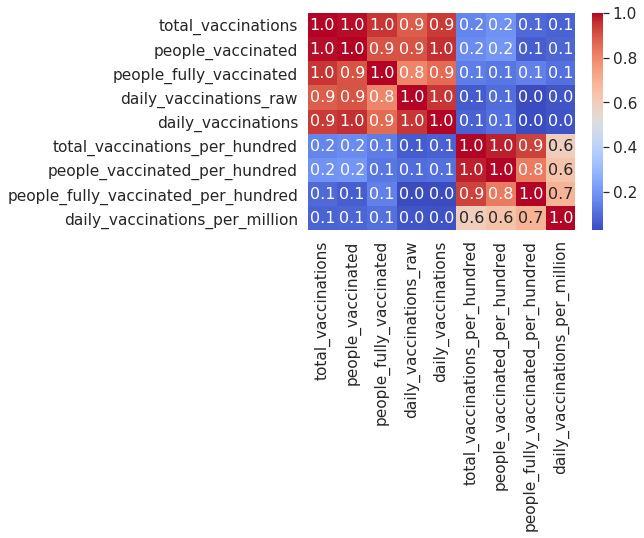

In [11]:
# Find Correlations between columns
numerical_cols = list(covid_orig_df.describe().columns)
sns.set(font_scale=1.4)
sns.heatmap(data=covid_orig_df[numerical_cols].corr(), 
            cmap='coolwarm', annot=True, fmt=".1f",annot_kws={'size':16})

/home/drkostas/anaconda3/envs/data_mining/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


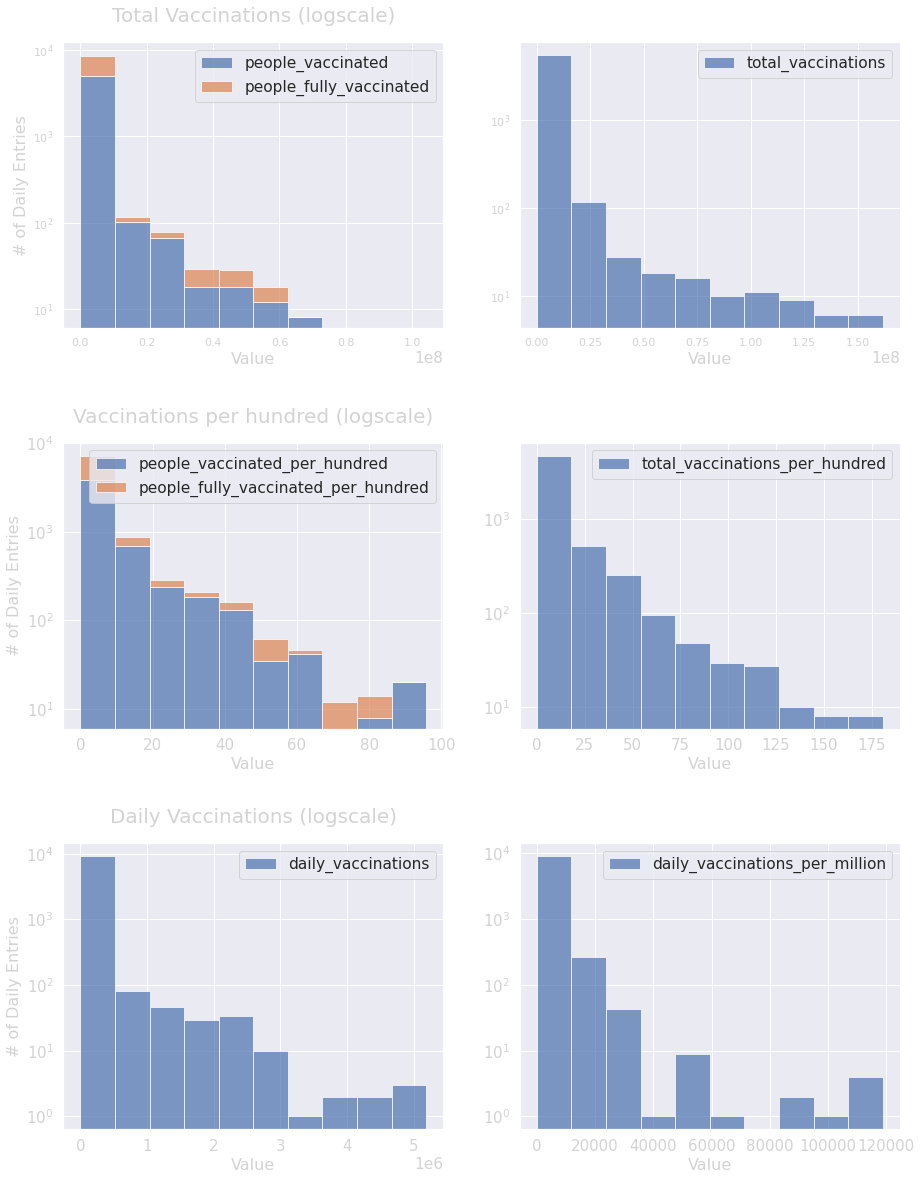

In [12]:
# Plot histograms with the values of important numerical columns
def plot_vaccine_columns(covid_orig_df):
    # Configure the grid of the plot
    fig, _ = plt.subplots(nrows=5, ncols=1, figsize=(15, 20))
    ax = []
    ax.append(plt.subplot2grid((3, 2), (0, 0), fig=fig))
    ax.append(plt.subplot2grid((3, 2), (0, 1), fig=fig))
    ax.append(plt.subplot2grid((3, 2), (1, 0), fig=fig))
    ax.append(plt.subplot2grid((3, 2), (1, 1), fig=fig))
    ax.append(plt.subplot2grid((3, 2), (2, 0), fig=fig))
    ax.append(plt.subplot2grid((3, 2), (2, 1), fig=fig))
    plt.subplots_adjust(hspace=0.4)

    # Plot using Pandas

    # First Row - First Column
    ax[0].tick_params(axis="both", colors=text_color)
    ax[0].set_title('Total Vaccinations (logscale)', fontsize=20, c=text_color)
    covid_orig_df[['people_vaccinated', 'people_fully_vaccinated']]\
                .plot.hist(ax=ax[0], fontsize=11, alpha=0.7, logy=True, stacked=True)
    ax[0].set_xlabel('Value', fontsize=16, c=text_color)
    ax[0].set_ylabel('# of Daily Entries', fontsize=16, c=text_color)
    # First Row - Second Column
    ax[1].tick_params(axis="both", colors=text_color)
    covid_orig_df[['total_vaccinations']]\
                .plot.hist(ax=ax[1], fontsize=11, alpha=0.7, logy=True)
    ax[1].set_xlabel('Value', fontsize=16, c=text_color)
    ax[1].set_ylabel('')
    # Second Row - First Column
    ax[2].tick_params(axis="both", colors=text_color)
    ax[2].set_title('Vaccinations per hundred (logscale)', fontsize=20, c=text_color)
    covid_orig_df[['people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred']]\
                .plot.hist(ax=ax[2], fontsize=15, alpha=0.7, logy=True, stacked=True)
    ax[2].set_xlabel('Value', fontsize=16, c=text_color)
    ax[2].set_ylabel('# of Daily Entries', fontsize=16, c=text_color)
    # Second Row - Second Column
    ax[3].tick_params(axis="both", colors=text_color)
    covid_orig_df[['total_vaccinations_per_hundred']]\
                .plot.hist(ax=ax[3], fontsize=15, alpha=0.7, logy=True)
    ax[3].set_xlabel('Value', fontsize=16, c=text_color)
    ax[3].set_ylabel('', fontsize=16, c=text_color)
    # Third Row - First Column
    ax[4].tick_params(axis="both", colors=text_color)
    ax[4].set_title('Daily Vaccinations (logscale)', fontsize=20, c=text_color)
    covid_orig_df[['daily_vaccinations']]\
                .plot.hist(ax=ax[4], fontsize=15, alpha=0.7, logy=True, stacked=True)
    ax[4].set_xlabel('Value', fontsize=16, c=text_color)
    ax[4].set_ylabel('# of Daily Entries', fontsize=16, c=text_color)
    # Third Row - Second Column
    ax[5].tick_params(axis="both", colors=text_color)
    covid_orig_df[['daily_vaccinations_per_million']]\
                .plot.hist(ax=ax[5], fontsize=15, alpha=0.7, logy=True)
    ax[5].set_xlabel('Value', fontsize=16, c=text_color)
    ax[5].set_ylabel('', fontsize=16, c=text_color)

# Call the plotting function
plot_vaccine_columns(covid_orig_df)

### Transform/Clean the dataset

#### Visualize null values

HeatMap Description
- -1: Exact Negative correlation represents that if the value of one variable is present then the value of other variables is definitely absent.
- 0: No correlation represents that variables values present or absent do not have any effect on one another.
- 1: Exact Positive correlation represents that if the value of one variable is present then the value of the other is definitely present


2021-04-20 14:02:52 JupyterMain  INFO     Missing Values:
country                                   0
iso_code                                  0
date                                      0
vaccines                                  0
people_vaccinated                      4409
people_fully_vaccinated                5968
total_vaccinations                     3804
people_vaccinated_per_hundred          4409
people_fully_vaccinated_per_hundred    5968
total_vaccinations_per_hundred         3804
daily_vaccinations                      183
daily_vaccinations_per_million          183
dtype: int64


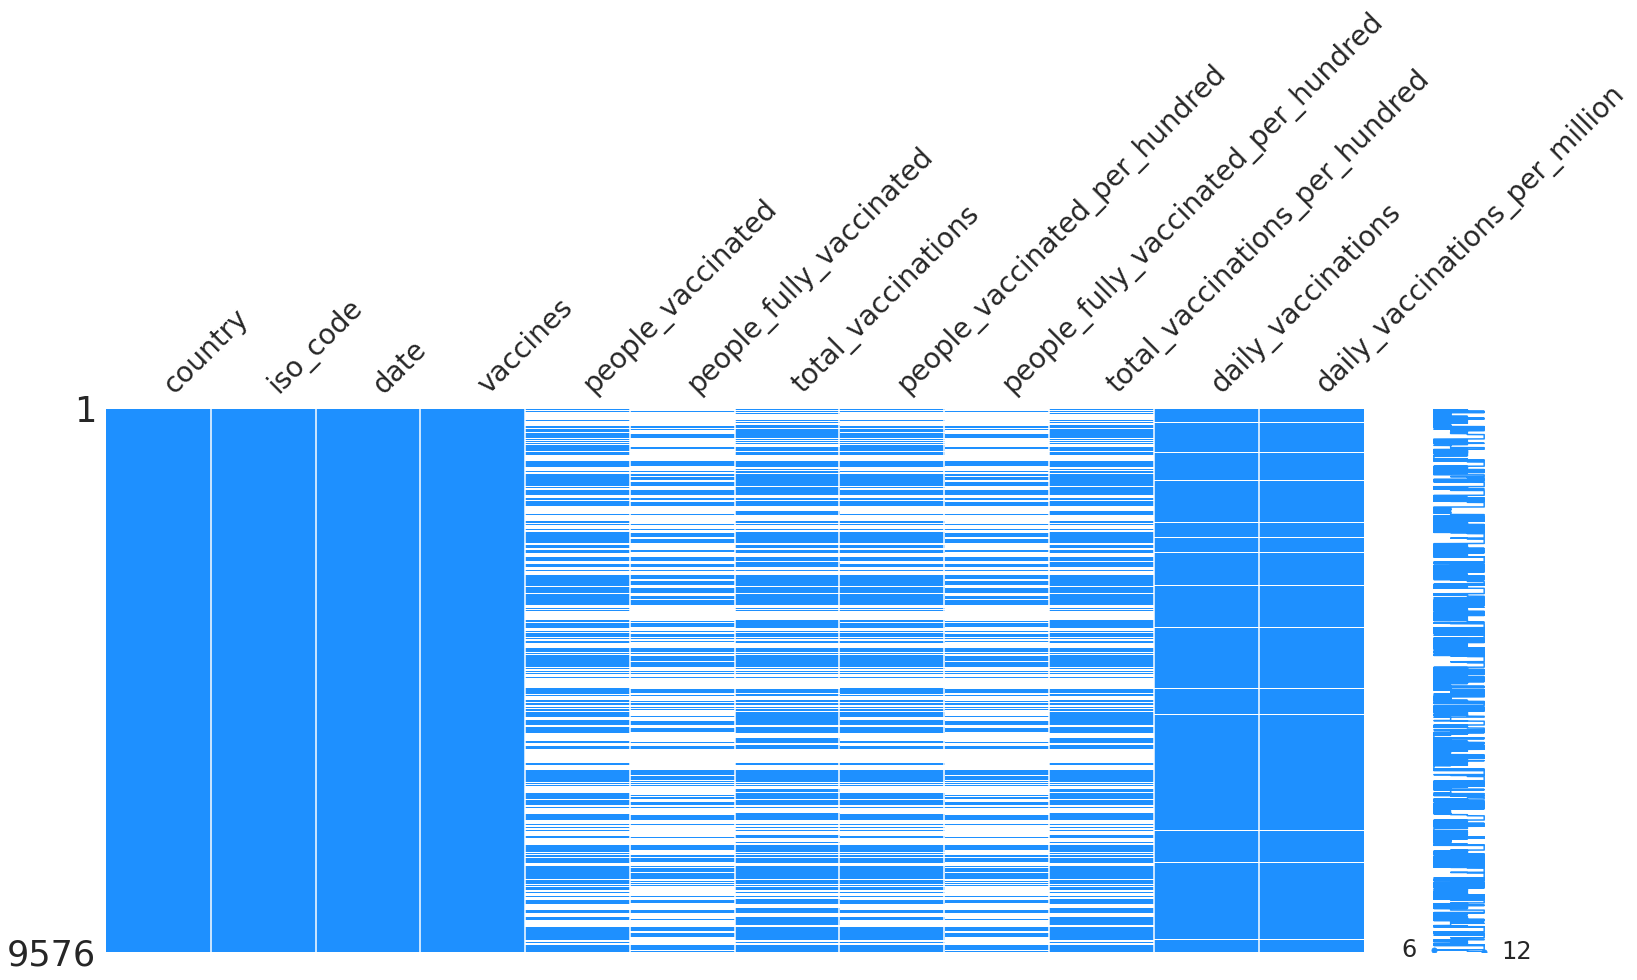

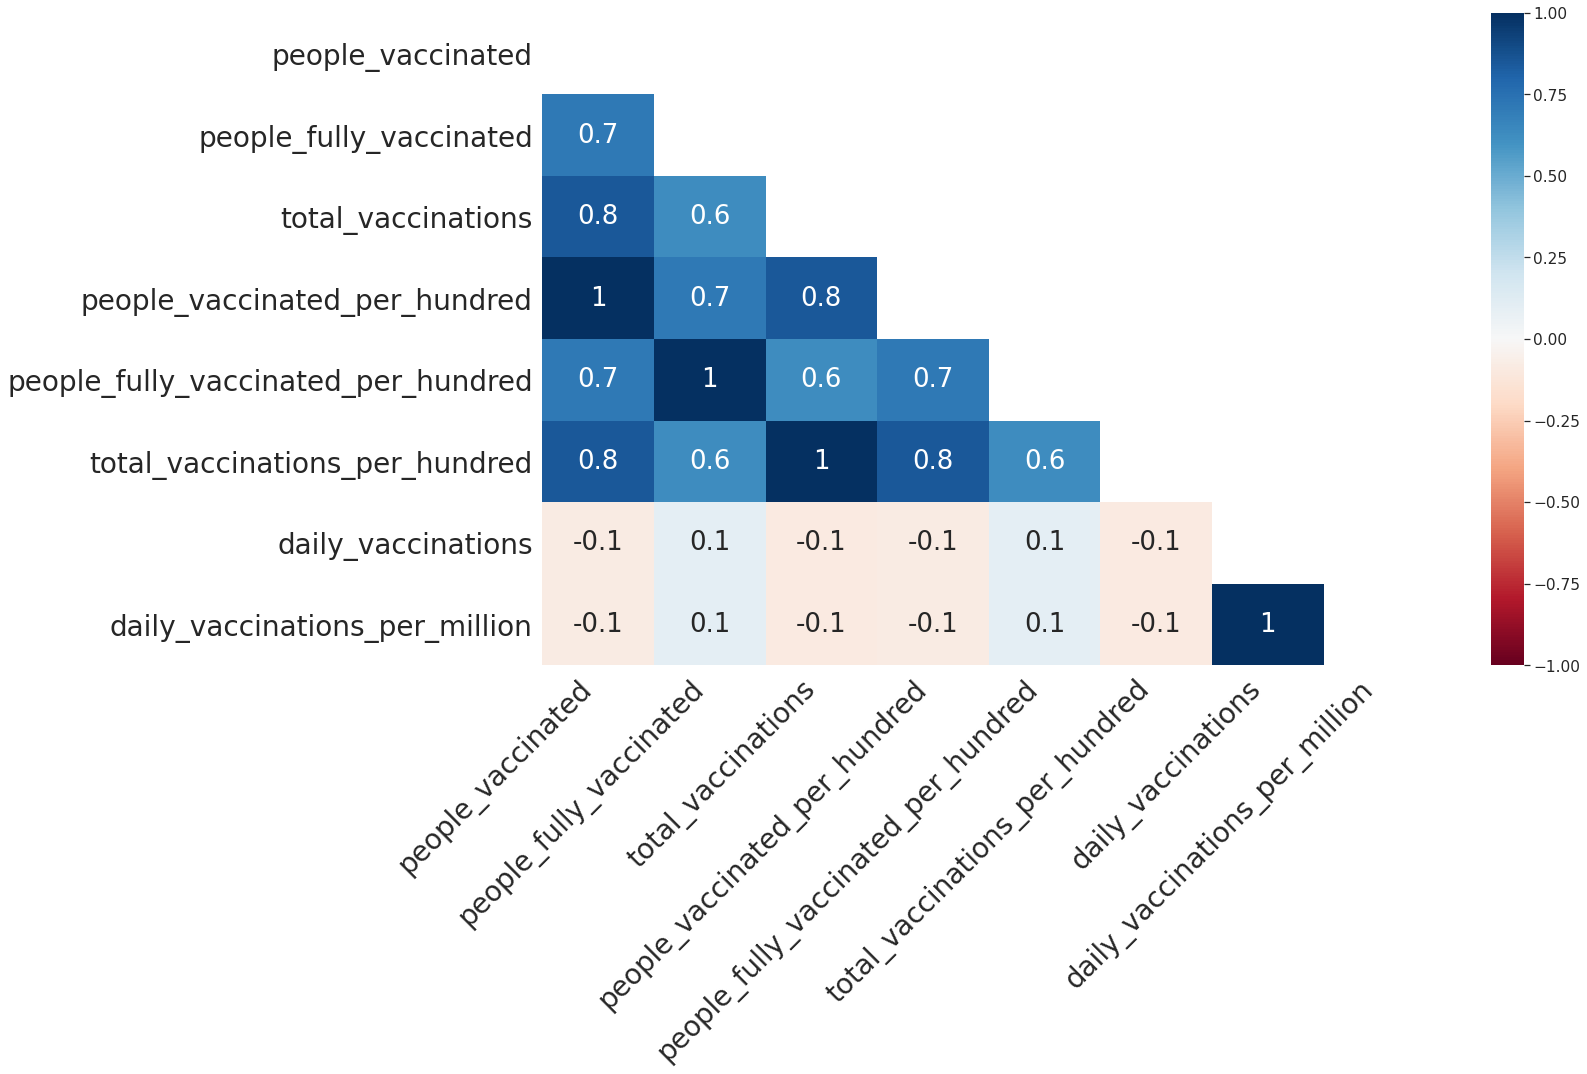

In [13]:
# Visualize Missing Values
def viz_missing_vals(df, cols, skip_1=False, skip_2=False):
    logger.info(f"Missing Values:\n{df[cols].isna().sum()}")
    df = df[cols]
    # msno.bar(covid_df, fontsize=24, color="dodgerblue")
    # Visualize rows to find which columns are null
    if not skip_1:
        msno.matrix(df, fontsize=28, color=(0.118, 0.565, 1)) #, sort='ascending')
    # Visualize heatmap to find correlations between columns when they have null values
    if not skip_2:
        msno.heatmap(df, cmap="RdBu", fontsize=28)
    
important_cols = ['country', 'iso_code', 'date', 'vaccines', 
                      'people_vaccinated', 'people_fully_vaccinated', 'total_vaccinations', 
                      'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 
                      'total_vaccinations_per_hundred','daily_vaccinations', 
                      'daily_vaccinations_per_million']
covid_df = covid_orig_df[important_cols]
viz_missing_vals(covid_df, important_cols)

We find that the columns with most missing values are:
- people_vaccinated 
- people_fully_vaccinated
- total_vaccinations
- people_vaccinated_per_hundred
- people_fully_vaccinated_per_hundred
- total_vaccinations_per_hundred

We also find that the missing values of daily_vaccinations and daily_vaccinations_per_million are not correlated with any other columns. It's of course obvious that columns with their per_hunder or per_million versions are always missing at the same time.
<br>
Let's print some of the rows with missing values to see exactly what's happening.

#### Fix nulls for the columns:
- `daily_vaccinations`
- `total_vaccinations`
- `people_vaccinated`
- `people_fully_vaccinated`

In [14]:
def d(df, cols, n=19, print_table=True):
    """ Function for printing the number of nulls per column"""
    df = df.loc[:, cols]
    if print_table:
        display(df.head(n))
    missings = df.isna().sum()
    logger.info(f"Missing Values (all):\n{missings}")
    return missings

    
covid_df_clean = covid_df.copy() # \
#                          .loc[covid_df.iso_code=='USA', :] \
#                          .reset_index(drop=True)
n = 5
cols = ['country', 'iso_code', 'date', 'daily_vaccinations', 'total_vaccinations',
        'people_vaccinated', 'people_fully_vaccinated']

reload_lib(nullib)
nf = nullib.NullsFixer(sort_col='date', group_col='iso_code')

# while nulls didn't change
_ = d(covid_df_clean, cols, n, False)
covid_df_clean = nf.fix_and_infer(covid_df_clean)
_ = d(covid_df_clean, cols, n, False)


2021-04-20 14:02:53 JupyterMain  INFO     Missing Values (all):
country                       0
iso_code                      0
date                          0
daily_vaccinations          183
total_vaccinations         3804
people_vaccinated          4409
people_fully_vaccinated    5968
dtype: int64
2021-04-20 14:06:10 JupyterMain  INFO     Missing Values (all):
country                    0
iso_code                   0
date                       0
daily_vaccinations         0
total_vaccinations         0
people_vaccinated          0
people_fully_vaccinated    0
dtype: int64


In [15]:
# # # Temp
# covid_orig_tmp  = covid_df.copy()
# covid_orig_tmp = covid_orig_tmp .reset_index(drop=True)
# ccols = ['total_vaccinations', 'previous_total_vaccinations', 'daily_vaccinations'] + cols

# cond = (lambda df: 
#         ((df.people_fully_vaccinated > df.total_vaccinations) |
#         (df.people_vaccinated > df.total_vaccinations) |
#         (df.people_vaccinated<0) |
#         (df.people_fully_vaccinated<0) |
#         (df.total_vaccinations<0) |
#         (df.daily_vaccinations<0) |
#         (df.people_fully_vaccinated+df.people_vaccinated
#          >df.total_vaccinations)))
# cond_1 = (lambda df:  (df.people_fully_vaccinated > df.total_vaccinations))
# cond_2 = (lambda df:  (df.people_vaccinated > df.total_vaccinations))
# cond_3 = (lambda df:  (df.people_vaccinated<0))
# cond_4 = (lambda df:  (df.people_fully_vaccinated<0))
# cond_5 = (lambda df:  (df.total_vaccinations<0))
# cond_6 = (lambda df:  (df.daily_vaccinations<0))
# cond_7 = (lambda df:  (df.people_fully_vaccinated+df.people_vaccinated>
#                        df.total_vaccinations))
# conds = (cond, cond_1, cond_2, cond_3, cond_4, cond_5, cond_6, cond_7)

In [16]:
# # # Temp

# # Print num Problems for each case
# for cond in conds[:]:
#     print("Problem: ", conds.index(cond))
# #     print("Original")
# #     display(covid_orig_tmp.loc[cond(covid_orig_tmp), :].country.value_counts().sum())
#     print("Problems in cleaned: ",
#          covid_df_clean.loc[cond(covid_df_clean), :].country.value_counts().sum())

# # Per Country
# display(covid_df_clean.loc[cond, :].country.value_counts())
# # Indices
# # print("Indices of original")
# # display(covid_orig_tmp.loc[conds[7](covid_orig_tmp), :].index)
# print("Indices of result")
# # reload_lib(nullib)
# # nf = nullib.NullsFixer(sort_col='date', group_col='iso_code')
# # df_test = covid_df_clean.copy().apply(nf.global_fix, axis=1)
# covid_df_clean.loc[:, 'diff'] = covid_df_clean['total_vaccinations'] \
#                                  - covid_df_clean['people_vaccinated'] \
#                                  - covid_df_clean['people_fully_vaccinated']
# cccols = ['diff'] + ccols
# display(covid_df_clean.loc[conds[7](covid_df_clean), :].index)
# # Original
# # display(covid_orig_tmp.loc[:, cols]\
# #         .iloc[83:105].transpose())
# # Result
# display(covid_df_clean.loc[:, cccols]\
#         .iloc[83:105]\
#         .transpose())
# # Show rows with problems
# # display(covid_df_clean.loc[cond1, :])

#### Load dataset with countries metadata

In [17]:
# Load the metadata dataset
if covid_conf['type'] == 'csv':
    countries_meta_orig_df = pd.read_csv(data_extra_path)
    logger.info("Dataset loaded.")
else:
    logger.error('Data type not supported!')

2021-04-20 14:06:10 JupyterMain  INFO     Dataset loaded.


In [18]:
# Print Columns info
logger.info(f"Dataframe shape: {countries_meta_orig_df.shape}")
# Print the first two rows|
display(countries_meta_orig_df.head(n=2).transpose())
countries_meta_orig_df.columns

2021-04-20 14:06:10 JupyterMain  INFO     Dataframe shape: (265, 11)


,0,1
,Afghanistan,Albania
"Population, total","38,041,754.0","2,854,191.0"
"Community health workers (per 1,000 people)",..,..
Unnamed: 3,NaN,NaN
Current health expenditure (% of GDP),9.4,5.3
"Life expectancy at birth, total (years)",64.5,78.5
People using at least basic sanitation services (% of population),43.4,97.7
"Hospital beds (per 1,000 people)",0.4,2.9
People with basic handwashing facilities including soap and water (% of population),37.7,..
"Physicians (per 1,000 people)",0.3,1.2


Index([' ', 'Population, total', 'Community health workers (per 1,000 people)',
       'Unnamed: 3', 'Current health expenditure (% of GDP)',
       'Life expectancy at birth, total (years)',
       'People using at least basic sanitation services (% of population)',
       'Hospital beds (per 1,000 people)',
       'People with basic handwashing facilities including soap and water (% of population)',
       'Physicians (per 1,000 people)',
       'Mortality rate attributed to unsafe water, unsafe sanitation and lack of hygiene (per 100,000 population)'],
      dtype='object')

In [19]:
# Preprocess the metadata dataset
countries_meta_df_clean = countries_meta_orig_df.copy()
# Rename Columns
name_replacements = {
    ' ': 'country',
    'Country Code': 'iso_code',
    'Population, total': 'population',
    'Community health workers (per 1,000 people)': 'health_workers_per_1000',
    'Current health expenditure (% of GDP)': 'health_expenditure_per_gdp',
    'Hospital beds (per 1,000 people)': 'hospital_beds_per_1000',
    'Life expectancy at birth, total (years)': 'life_expectancy_at_birth',
    'People using at least basic sanitation services (% of population)': 'perc_using_sanitation_services',
    'People with basic handwashing facilities including soap and water (% of population)': 'perc_using_handwashing_facilities',
    'Physicians (per 1,000 people)': 'physicians_per_1000',
    'Mortality rate attributed to unsafe water, unsafe sanitation and lack of hygiene (per 100,000 population)': 'mortality_by_hygiene_per_100000'
}
countries_meta_df_clean = countries_meta_df_clean.rename(columns=name_replacements)
countries_meta_df_clean = countries_meta_df_clean.drop(columns=["Unnamed: 3"])
# countries_meta_df_clean = countries_meta_df_clean.drop(columns=["Time Code"])
# countries_meta_df_clean['year'] = pd.to_numeric(countries_meta_df_clean.year, errors='coerce')
countries_meta_df_clean = countries_meta_df_clean[countries_meta_df_clean['country'].notna()]
# countries_meta_df_clean = countries_meta_df_clean[countries_meta_df_clean['year'].notna()]
# Strip
countries_meta_df_clean.loc[:, 'country'] = countries_meta_df_clean['country'].str.strip()
# Fix some names
countries_meta_df_clean.loc[:, 'country'] = countries_meta_df_clean['country']\
                                            .replace('Czech Republic', 'Czechia')\
                                            .replace('Brunei Darussalam', 'Brunei')\
                                            .replace('Cabo Verde', 'Cape Verde')\
                                            .replace('Slovak Republic', 'Slovakia')\
                                            .replace('Korea, Rep.', 'South Korea')\
                                            .replace('Faroe Islands', 'Faeroe Islands')\
                                            .replace('Lao PDR', 'Laos')\
                                            .replace('Ireland', 'Northern Ireland')\
                                            .str.replace(', The', '')\
                                            .str.replace(r',.*Rep.', '')\
                                            .str.replace('&', 'and')\
                                            .str.replace('St\.', 'Saint')\
                                            .str.replace('n Federation', '')\
                                            .str.replace(', RB', '')\
                                            .str.replace(' SAR, China', '')
countries_meta_df_clean.loc[:, 'population'] = countries_meta_df_clean['population']\
                                                .str.replace(',', '')

display(countries_meta_df_clean\
        #.loc[countries_meta_df_clean['country'].str.contains('United'), 'country']\
        .head(n=2).transpose())
countries_meta_df_clean.dtypes

<ipython-input-19-f1f11a562985>:26: FutureWarning: The default value of regex will change from True to False in a future version.
  countries_meta_df_clean.loc[:, 'country'] = countries_meta_df_clean['country']\


,0,1
country,Afghanistan,Albania
population,38041754.0,2854191.0
health_workers_per_1000,..,..
health_expenditure_per_gdp,9.4,5.3
life_expectancy_at_birth,64.5,78.5
perc_using_sanitation_services,43.4,97.7
hospital_beds_per_1000,0.4,2.9
perc_using_handwashing_facilities,37.7,..
physicians_per_1000,0.3,1.2
mortality_by_hygiene_per_100000,13.9,0.2


country                              object
population                           object
health_workers_per_1000              object
health_expenditure_per_gdp           object
life_expectancy_at_birth             object
perc_using_sanitation_services       object
hospital_beds_per_1000               object
perc_using_handwashing_facilities    object
physicians_per_1000                  object
mortality_by_hygiene_per_100000      object
dtype: object

In [80]:
# Check the overlap between the 2 datasets
covid_df_clean_2 = covid_df_clean.copy()
unique_countries_covid = list(covid_df_clean_2['country'].unique())
unique_countries_metadata = list(countries_meta_df_clean['country'].unique())
# Overlap
overlap = set(unique_countries_covid).issubset(unique_countries_metadata)
logger.info(f"Are all the countries from out dataset included in the metadata dataset? \
            {overlap}")
# Difference
not_included = set(unique_countries_covid).difference(unique_countries_metadata)
logger.info(f"Countries not included:\n{sorted(not_included)}")
# logger.info(f"Countries from metadata:\n{sorted(unique_countries_metadata)}")

2021-04-20 15:15:59 JupyterMain  INFO     Are all the countries from out dataset included in the metadata dataset?             False
2021-04-20 15:15:59 JupyterMain  INFO     Countries not included:
['Anguilla', 'England', 'Falkland Islands', 'Guernsey', 'Ireland', 'Jersey', 'Montserrat', 'Northern Cyprus', 'Palestine', 'Saint Helena', 'Scotland', 'Taiwan', 'Wales']


In [81]:
# Let's drop them as for example UK includes England, Wales, Scotland
covid_df_clean_2 = covid_df_clean_2[~covid_df_clean_2['country'].isin(not_included)]
unique_countries_covid = list(covid_df_clean_2['country'].unique())
# Overlap
overlap = set(unique_countries_covid).issubset(unique_countries_metadata)
logger.info(f"Are all the countries from out dataset included in the metadata dataset? \
            {overlap}")

2021-04-20 15:16:00 JupyterMain  INFO     Are all the countries from out dataset included in the metadata dataset?             True


#### Use the new information to fix the `per_hunded` and `per_million` nulls

2021-04-20 15:16:01 JupyterMain  INFO     Missing Values:
country                                0
population                             2
health_workers_per_1000              193
health_expenditure_per_gdp            29
hospital_beds_per_1000                34
life_expectancy_at_birth              11
perc_using_sanitation_services         6
perc_using_handwashing_facilities    154
physicians_per_1000                   19
mortality_by_hygiene_per_100000       36
dtype: int64


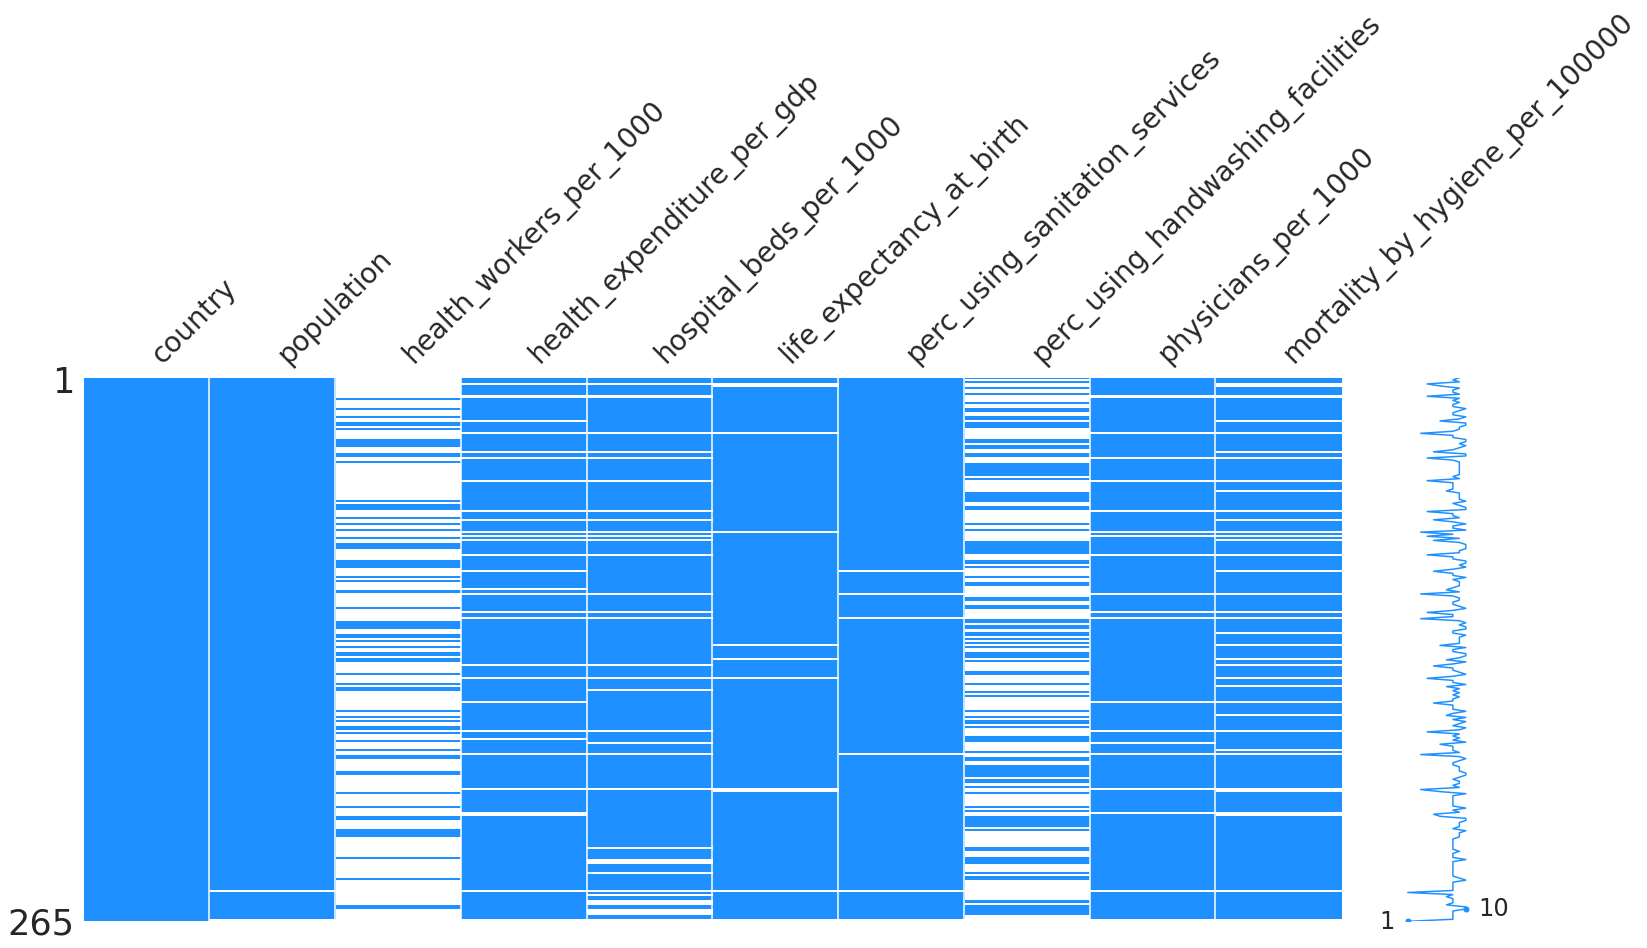

In [82]:
# Prepare the meta dataset
countries_meta_df_clean_2 = countries_meta_df_clean.copy()
cols = ['country', 'population', 'health_workers_per_1000', 'health_expenditure_per_gdp',
        'hospital_beds_per_1000', 'life_expectancy_at_birth', 
        'perc_using_sanitation_services', 'perc_using_handwashing_facilities', 
        'physicians_per_1000', 'mortality_by_hygiene_per_100000']
for col in cols[1:]:
    countries_meta_df_clean_2.loc[:, col] = pd.to_numeric(countries_meta_df_clean_2[col], errors='coerce')
#     countries_meta_df_clean_2.loc[:, [col]] = countries_meta_df_clean_2.loc[:, [col]]\
#                                     .groupby(countries_meta_df_clean_2['country'])\
#                                     .ffill()
viz_missing_vals(countries_meta_df_clean_2, cols, skip_2=True)
# Drop columns with many nulls
cols_to_drop = ["health_workers_per_1000", "perc_using_handwashing_facilities"]
countries_meta_df_clean_2 = countries_meta_df_clean_2.drop(columns=cols_to_drop)
cols = list(set(cols).difference(set(cols_to_drop)))

In [84]:
# Recalculate the per 100 and per million values using the new dataset
reload_lib(nullib)
nf = nullib.NullsFixer(sort_col='date', group_col='iso_code')

covid_df_clean_3 = nf.fill_with_population(covid_df_clean_2.copy(), 
                                           countries_meta_df_clean_2)
# Then scale them to incorporate possible errors
cols_to_scale = [("people_vaccinated_per_hundred", 100),
                ("people_fully_vaccinated_per_hundred", 100),
                ("total_vaccinations_per_hundred", 100),
                ("daily_vaccinations_per_million", 1000000)]
for (col, max_val) in cols_to_scale:
    vals = covid_df_clean_3[[col]].values  # returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, max_val))
    vals_scaled_df =  pd.DataFrame(min_max_scaler.fit_transform(vals),
                                  columns=[col])
    covid_df_clean_3.loc[:, col] = vals_scaled_df[col]

We are done with the handling of nulls!

#### Now let's enrich our dataset with some other attributes of the new dataset

2021-04-20 15:17:23 JupyterMain  INFO     Missing Values:
perc_using_sanitation_services     0
physicians_per_1000                0
hospital_beds_per_1000             0
population                         0
mortality_by_hygiene_per_100000    0
country                            0
life_expectancy_at_birth           0
health_expenditure_per_gdp         0
dtype: int64


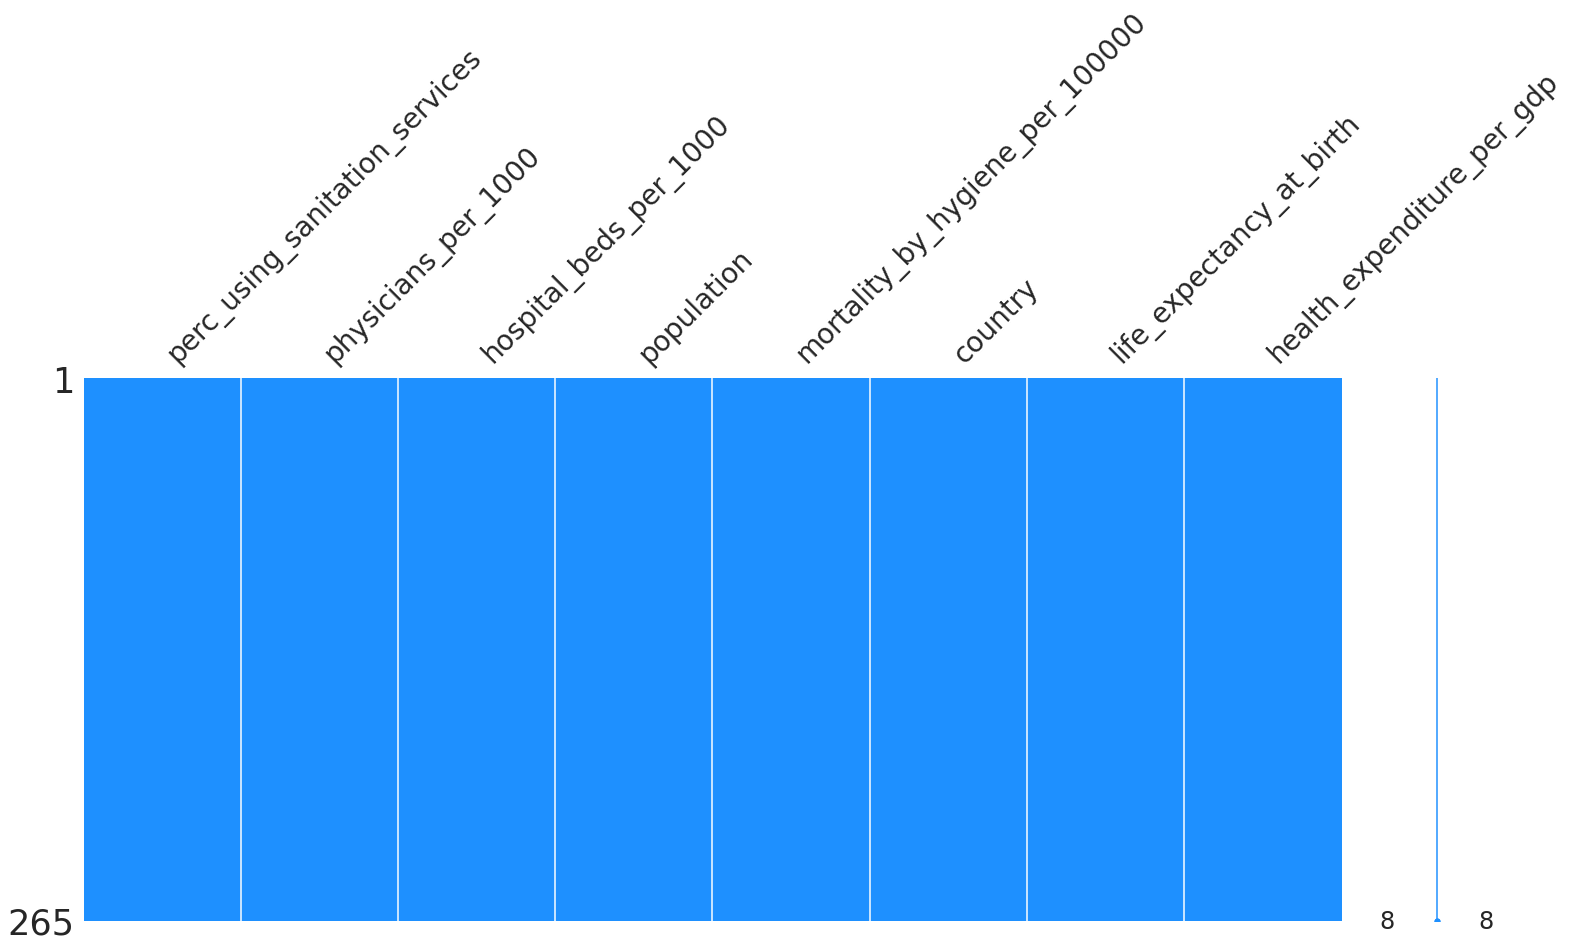

In [85]:
# First fillna for the metadata dataset using interpolation
countries_meta_df_clean_3 = countries_meta_df_clean_2.copy()
countries_meta_df_clean_3 = countries_meta_df_clean_3.interpolate()
viz_missing_vals(countries_meta_df_clean_3, cols, skip_2=True)


In [86]:
# Now match these values with the covid dataset
covid_df_clean_4 = covid_df_clean_3.merge(countries_meta_df_clean_3, 
                                         on='country',
                                         how='left')
display(covid_df_clean_4.head(2).transpose())

,0,1
country,Northern Ireland,United Kingdom
iso_code,OWID_NIR,GBR
date,2020-12-13 00:00:00,2020-12-13 00:00:00
vaccines,"Oxford/AstraZeneca, Pfizer/BioNTech","Oxford/AstraZeneca, Pfizer/BioNTech"
people_vaccinated,3623.0,86465.0
people_fully_vaccinated,0.0,0.0
total_vaccinations,3623.0,86465.0
people_vaccinated_per_hundred,0.114763,0.0
people_fully_vaccinated_per_hundred,0.0,0.0
total_vaccinations_per_hundred,0.060847,0.0


#### Feature Engineering

In [87]:
# OneHotEncode the 'vaccines' columns
display(covid_df_clean_4[['vaccines']].head(2))
onehotencoded_df = covid_df_clean_4.vaccines.str.split('\s*,\s*', expand=True).stack()\
                      .str.get_dummies().sum(level=0)
covid_df_clean_5 =covid_df_clean_4.join(onehotencoded_df)
display(covid_df_clean_5.head(2).transpose())
# Now we can drop the vaccines column
covid_df_clean_5 = covid_df_clean_5.drop(columns=['vaccines'])

,vaccines
0,"Oxford/AstraZeneca, Pfizer/BioNTech"
1,"Oxford/AstraZeneca, Pfizer/BioNTech"


,0,1
country,Northern Ireland,United Kingdom
iso_code,OWID_NIR,GBR
date,2020-12-13 00:00:00,2020-12-13 00:00:00
vaccines,"Oxford/AstraZeneca, Pfizer/BioNTech","Oxford/AstraZeneca, Pfizer/BioNTech"
people_vaccinated,3623.0,86465.0
people_fully_vaccinated,0.0,0.0
total_vaccinations,3623.0,86465.0
people_vaccinated_per_hundred,0.114763,0.0
people_fully_vaccinated_per_hundred,0.0,0.0
total_vaccinations_per_hundred,0.060847,0.0


#### Plot what we currenlty have

In [89]:
plot_data = covid_df_clean_5.copy()

In [ ]:
top_n = 25
# Plot total vaccinations per country (top 25)
vacc_amount = plot_data.groupby('country').max()\
                        .sort_values('total_vaccinations', ascending=False)\
                        .head(top_n)
fig, ax = plt.subplots(figsize=(12, 25), nrows = 3, ncols = 1)
plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
ax[0].bar(vacc_amount.index, vacc_amount.total_vaccinations)
ax[0].tick_params(labelrotation=90, axis='x')
ax[0].set_title(f"Total vaccinations (Top {top_n} Countries)")
ax[0].set_ylabel('Amount of vaccinated citizens')
ax[0].set_xlabel('Countries')
# Plot total vaccinations per 100 per country (top 25)
vacc_amount = plot_data.groupby('country').max()\
                        .sort_values('total_vaccinations_per_hundred', 
                                     ascending=False)\
                        .head(50)
ax[1].bar(vacc_amount.index, vacc_amount.total_vaccinations_per_hundred)
ax[1].tick_params(labelrotation=90, axis='x')
ax[1].set_title(f"Total vaccinations per 100 (Top {top_n} Countries)")
ax[1].set_ylabel('Amount of vaccinated citizens per 100 citizens')
ax[1].set_xlabel('Countries')
# Plot total vaccinations per 100 per vaccines (top 25)
vacc_amount = plot_data.groupby('country').mean()\
                        .sort_values('daily_vaccinations_per_million', 
                                     ascending=False)\
                        .head(50)
ax[2].bar(vacc_amount.index, vacc_amount.daily_vaccinations_per_million)
ax[2].tick_params(labelrotation=90, axis='x')
ax[2].set_title(f"AVG daily vaccinations per million (Top {top_n} Countries)")
ax[2].set_ylabel('AVG daily vaccinations per million')
ax[2].set_xlabel('Countries')
# Show Plot
plt.show()

#### Normalize, Standarize

In [ ]:

covid_df_clean_6 = covid_df_clean_5.copy()

cols_to_scale = [""]
vals = covid_df_clean_6.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
vals_scaled = min_max_scaler.fit_transform(vals)
covid_df_clean_6 = pd.DataFrame(vals_scaled)

In [42]:
# Pivot Table for each country
pd.pivot_table(covid_df_clean_5, index='iso_code', 
               values = ['people_vaccinated_per_hundred',
                         'people_fully_vaccinated_per_hundred'])

,people_fully_vaccinated_per_hundred,people_vaccinated_per_hundred
iso_code,,
AFG,0.000000,0.059130
AGO,0.000000,0.136897
ALB,0.082169,0.651807
AND,0.579074,3.269259
ARE,36.957191,12.721798
ARG,0.548021,2.062500
ATG,0.000000,16.205000
AUS,0.000000,0.803125
AUT,1.761546,4.627526


In [ ]:
# Normalize, standarize

### Try to find naively find bottlnecks manually by looking at different countries data

In [ ]:
# Further feature engineering to find bottlnecks
# Create columns that indicate the average daily values for the past 3, 7, 14 days
# Similarly to GNU/Linux's Load Average
# Target columns can be a boolean that indicates if today's value is far too low compared
# to previous days
# Use these columns to guess bottlnecks
# Plotting a decision for these values tree may be useful

### First Stage of Clustering

In [ ]:
# Try different algorithms for this step
# Kmeans, DBSCAN, BIRCH, Mean Shift, OPTICS, Spectral Clustering, Gaussian Mixture Model

In [ ]:
# Evaluate the quality of the clusters
# Try to use exclude some columns to see how clustering changes
# Try Dimensionality Reduction to plot the results

### Use the clusters to see how the bottlnecks propage

In [ ]:
# Probably more feaure engineering needed
# Anomaly detection may be a good technique here
# Some Examples:
# https://medium.com/learningdatascience/anomaly-detection-techniques-in-python-50f650c75aaf

In [ ]:
# Theoritically the project can end here

### Data Enrichment


In [ ]:
# Try to enrich the dataset with more columns such GDP, region, %literacy, net migration
# Relecant Dataset: https://www.kaggle.com/fernandol/countries-of-the-world

### Recalculate clusters

In [ ]:
# Try to cluster again using the enriched dataset

### Predict again the bottlnecks

In [ ]:
# Use the new clusters to predict the bottlnecks

### Compare Results, Visualizations